# 0.0 Imports 

In [10]:
import inflection
import pickle
import math
import datetime 
import warnings
import seaborn  as sns
import pandas   as pd
import numpy    as np

from matplotlib              import pyplot as plt
from scipy                   import stats  as ss
from boruta                  import BorutaPy
from IPython.display         import Image
from IPython.core.display    import HTML
from sklearn                 import preprocessing
from sklearn.metrics         import mean_absolute_error, mean_squared_error
from sklearn.ensemble        import RandomForestRegressor
from sklearn.linear_model    import LinearRegression, Lasso
from sklearn.preprocessing   import RobustScaler, MinMaxScaler, LabelEncoder
from sklearn.model_selection import RandomizedSearchCV
from flask                   import Flask, request, Response

sns.set()
plt.rcParams['figure.figsize'] = [20,10]
warnings.filterwarnings( 'ignore' )

## Auxiliary Functions

In [11]:
def summary(data):
    numerical = data.select_dtypes(include=['int64','float64'])
    df_min = pd.DataFrame(numerical.apply(min)).T #Minimum
    df_max = pd.DataFrame(numerical.apply(max)).T #Maximum
    df_range = pd.DataFrame(numerical.apply(lambda x: x.max()-x.min())).T #Range
    df_median = pd.DataFrame(numerical.apply(np.median)).T #Mediam
    df_mean = pd.DataFrame(numerical.apply(np.mean)).T #Mean
    df_std = pd.DataFrame(numerical.apply(np.std)).T #Standard Deviation
    df_skew = pd.DataFrame(numerical.apply(lambda x: x.skew())).T #Skewness
    df_kurt = pd.DataFrame(numerical.apply(lambda x: x.kurtosis())).T #Kurtosis
    
    summary = pd.concat([df_min,df_max,df_range,df_median,df_mean,df_std,df_skew,df_kurt]).T #Concatenate statistics in a dataframe 
    summary.columns = ['Min','Max','Range','Median','Mean','Standard Deviation','Skewness','Kurtosis'] #Renamed columns
    
    return summary

def cramer_v( x, y ):
    cm = np.matrix(pd.crosstab( x, y ))
    n = cm.sum()
    r, k = cm.shape
    chi2 = ss.chi2_contingency( cm )[0]
    chi2corr = max( 0, chi2 - (k-1)*(r-1)/(n-1) )
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    return np.sqrt( (chi2corr/n) / ( min( kcorr-1, rcorr-1 ) ) )

def mean_absolute_error( y, yhat ):
    return np.mean(np.abs(y - yhat ))

def mean_absolute_percentage_error( y, yhat ):
    return np.mean( np.abs( ( y - yhat ) / y ) )

def mean_percentage_error( y, yhat ):
    return np.mean( ( y - yhat ) / y )

def ml_error( model_name, y, yhat ):
    mae = mean_absolute_error( y, yhat )
    mape = mean_absolute_percentage_error( y, yhat )
    rmse = np.sqrt( mean_squared_error( y, yhat ) )
    return pd.DataFrame( { 'Model Name': model_name,
                           'MAE': mae,
                           'MAPE': mape,
                           'RMSE': rmse }, 
                           index=[0] )


def cross_validation( x_training, kfold, model_name, model, verbose=False ):
    mae_list = []
    mape_list = []
    rmse_list = []
    for k in reversed( range( 1, kfold+1 ) ):      
        
        if verbose:
            print( '\nKFold Number: {}'.format( k ) )
        validation_start_date = x_training['date'].max() - datetime.timedelta(days=k*6*7)
        validation_end_date = x_training['date'].max() - datetime.timedelta(days=(k-1)*6*7)
        # filtering dataset
        training = x_training[x_training['date'] < validation_start_date]
        validation = x_training[(x_training['date'] >= validation_start_date) & (x_training['date'] <= validation_end_date)]
        # training and validation dataset
        # training
        xtraining = training.drop( ['date', 'sales'], axis=1 )
        ytraining = training['sales']
        # validation
        xvalidation = validation.drop( ['date', 'sales'], axis=1 )
        yvalidation = validation['sales']
        # model
        m = model.fit( xtraining, ytraining )
        # prediction
        yhat = m.predict( xvalidation )
        # performance
        m_result = ml_error( model_name, np.expm1( yvalidation ), np.expm1(yhat ) )
        # store performance of each kfold iteration
        mae_list.append( m_result['MAE'] )
        mape_list.append( m_result['MAPE'] )
        rmse_list.append( m_result['RMSE'] )
            
    return pd.DataFrame( {'Model Name': model_name,
                          'MAE CV': np.round( np.mean( mae_list ), 2 ).astype(str ) + ' +/- ' + np.round( np.std( mae_list ), 2 ).astype( str ),
                           'MAPE CV': np.round( np.mean( mape_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( mape_list ), 2 ).astype( str ),
                           'RMSE CV': np.round( np.mean( rmse_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( rmse_list ), 2 ).astype( str )},
                           index=[0] )

# 1.0 Data Description

In [12]:
df_train = pd.read_csv('train.csv') 
df_store = pd.read_csv('store.csv')

In [ ]:
df_train.head()

In [8]:
df_store.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [13]:
df = pd.merge(df_train,df_store, on='Store', how='left') #mergin datasets in df
df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


### 1.1 Columns Rename

In [14]:
#Renaming columns as snake case
cols_camelcase = list(df.columns)
snake_case = lambda x: inflection.underscore(x)
cols_snake_case = list(map(snake_case,cols_camelcase))
df.columns = cols_snake_case
df.columns

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval'],
      dtype='object')

### 1.2 Data Dimensions

In [5]:
#Data dimensions
print(f'The number of rows (observations) is {df.shape[0]}')
print(f'The number of columns (variables) is {df.shape[1]}')

The number of rows (observations) is 1017209
The number of columns (variables) is 18



### 1.3 Data Types

In [49]:
#Show data types
df.dtypes


store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

In [6]:
#Converting variable 'date' to type datetime
df['date'] = pd.to_datetime(df['date'])

### 1.4 Check NA

In [82]:
#Counting NA's in columns
df.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
dtype: int64

### 1.5 NA Replacing

In [7]:
#Repalcing 0 with '0'
df['state_holiday'] = df['state_holiday'].replace(0,'0')

# Replacing NA with a very high distance == no near competition 
df['competition_distance'] = df['competition_distance'].apply(lambda x: 200000.0 if math.isnan(x) else x) 

# Replacing NA with months == if diference between 'month store' and 'month open' equal zero, no competition open since month
df['competition_open_since_month'] = df.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis=1)

# Replacing NA with year == if diference between 'year store' and 'year open' equal zero, no competition open since year
df['competition_open_since_year'] = df.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis=1)

# Replacing NA with week == if diference between 'week store' and 'week since' equal zero, no promo participate since week
df['promo2_since_week'] = df.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis=1)

# Replacing NA with year == if diference between 'year store' and 'year since' equal zero, no promo participate since year
df['promo2_since_year'] = df.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis=1)

# Replacing NA with 0 = no promo
df['promo_interval'] = df['promo_interval'].fillna(0)



### 1.6 Changing Data Type

In [8]:
# competiton as int64
df['competition_open_since_month'] = np.int64(df['competition_open_since_month'])
df['competition_open_since_year'] = np.int64(df['competition_open_since_year'])

# promo2 as int64
df['promo2_since_week'] = np.int64(df['promo2_since_week'])
df['promo2_since_year'] = np.int64(df['promo2_since_year'])



### 1.7 Descriptive Statistics

In [9]:
df.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
promo_interval                          object
dtype: object

In [14]:
#Numeric and Categoric variables
numerical = df.select_dtypes(include=['int64','float64'])
categorical = df.select_dtypes(include=['object'])

#### 1.7.1 Numeric Variables Statistics


In [10]:
#Appling statistics in numeric variables
summary(df)

,Min,Max,Range,Median,Mean,Standard Deviation,Skewness,Kurtosis
store,1.0,1115.0,1114.0,558.0,558.429727,321.908493,-0.000955,-1.200524
day_of_week,1.0,7.0,6.0,4.0,3.998341,1.997390,0.001593,-1.246873
sales,0.0,41551.0,41551.0,5744.0,5773.818972,3849.924283,0.641460,1.778375
customers,0.0,7388.0,7388.0,609.0,633.145946,464.411506,1.598650,7.091773
open,0.0,1.0,1.0,1.0,0.830107,0.375539,-1.758045,1.090723
promo,0.0,1.0,1.0,0.0,0.381515,0.485758,0.487838,-1.762018
school_holiday,0.0,1.0,1.0,0.0,0.178647,0.383056,1.677842,0.815154
competition_distance,20.0,200000.0,199980.0,2330.0,5935.442677,12547.646829,10.242344,147.789712
competition_open_since_month,1.0,12.0,11.0,7.0,6.786849,3.311085,-0.042076,-1.232607
competition_open_since_year,1900.0,2015.0,115.0,2012.0,2010.324840,5.515591,-7.235657,124.071304


#### 1.7.2 Categoric Variables BoxPlot

state_holiday     4
store_type        4
assortment        3
promo_interval    4
dtype: int64


<AxesSubplot:xlabel='store_type', ylabel='sales'>

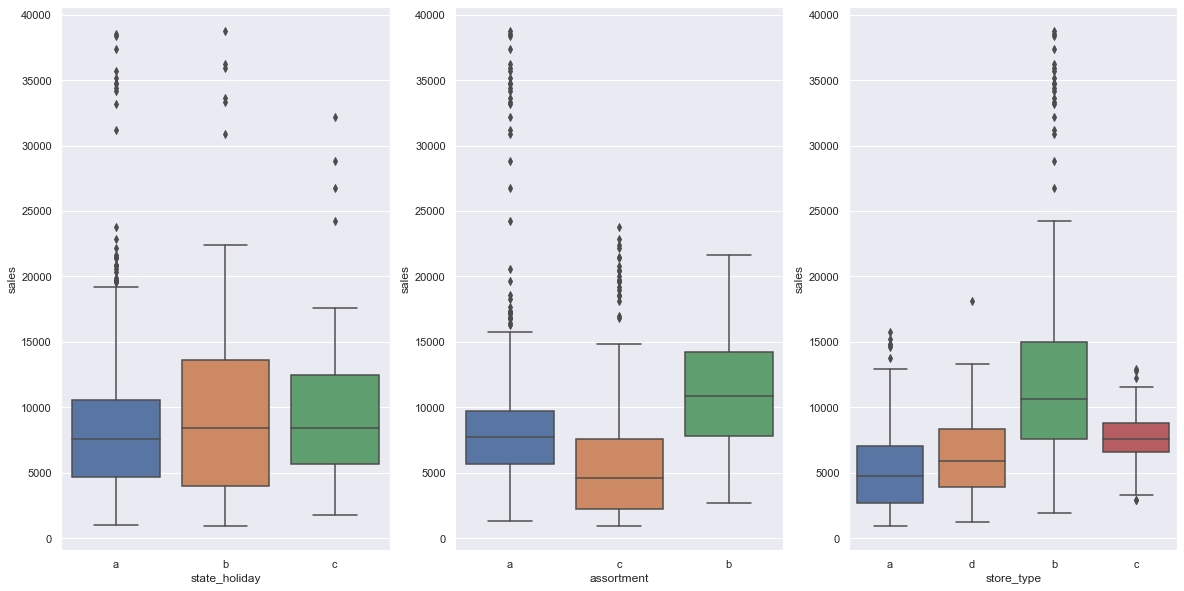

In [11]:
#Show levels of categoric variables
print(categorical.apply(lambda x: x.unique().shape[0]))

#Auxiliary dataset that only has sales
aux = df[(df['sales'] > 0) & (df['state_holiday'] != '0')]

#Boxplots
plt.subplot(1,3,1)
sns.boxplot(data = aux,x='state_holiday', y='sales')

plt.subplot(1,3,2)
sns.boxplot(data = aux,x='assortment', y='sales')

plt.subplot(1,3,3)
sns.boxplot(data = aux,x='store_type', y='sales')



# 2.0 Hipóteses e Feature Engineering

## 2.1 Mindmap Hyphotesis

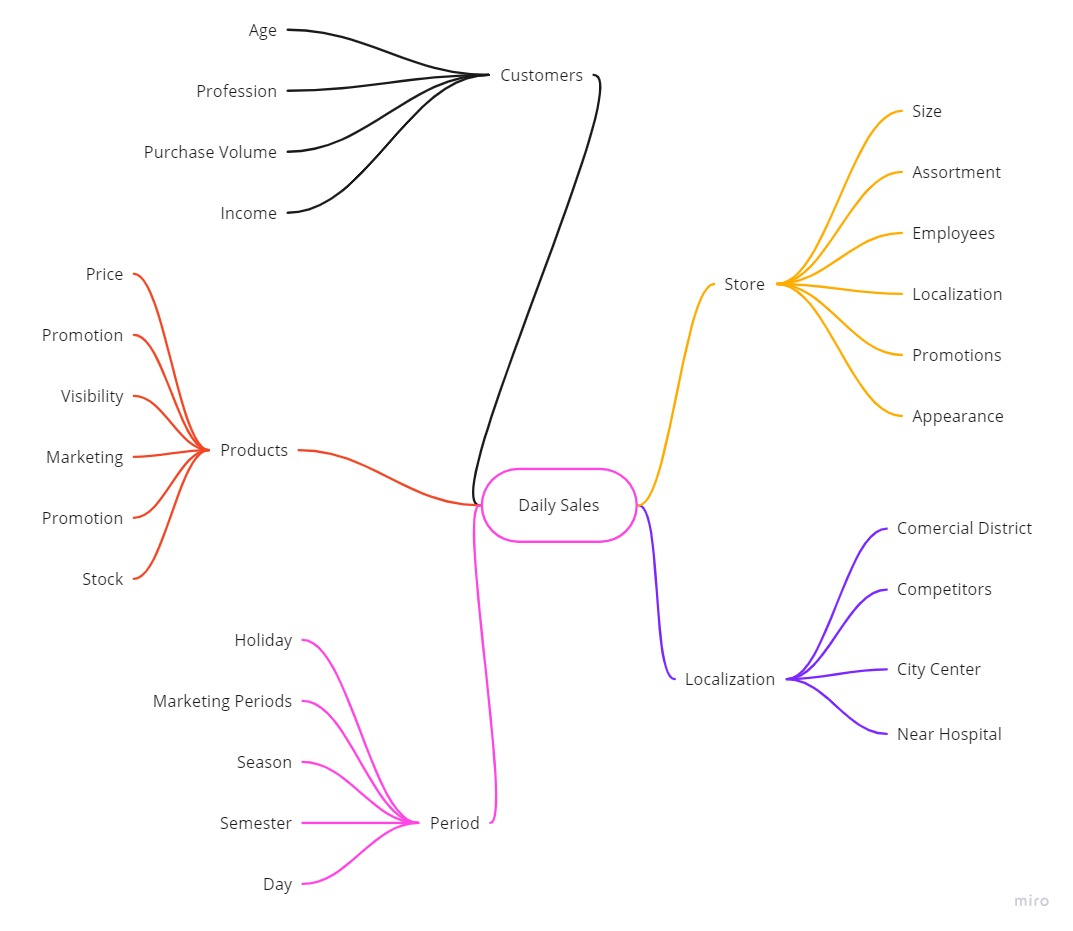

In [15]:
df2 = df.copy()
Image('mindmap.jpg')

## 2.2 Hypothesis

##### 2.2.1 Store
1 - Stores with the highest assortment are expected sell more

2 - Stores with more employees are expected to sell more 

3 - Stores in promotion are expected to sell more 

4 - Stores with close competitors should sell less

5 - Largest stores are expected to sell more

##### 2.2.2 Products 

6 - Products in promotion are expected to sell more

7 - Products that have a marketing campaign should sell more

8 - Products that have more stock are expected to sell more

##### 2.2.3  Period

9 - Stores should sell less in holidays

10 - Christmas is the best selling holiday

11 - Stores with more days of promotion should sell more

12 - Stores sell less in weekend

13 - Stores sells more in the second semester

14 - Stores should sell more over the years 

15 - Stores with competitors open for less time should sell less

##### 2.2.4 Localization

16 - Stores near to hospital are expected to sell more

17 - Stores in city center are expecter to sell more


## 2.3 Final list 

1 - Stores with the highest assortment are expected sell more

2 - Stores in promotion are expected to sell more

3 - Stores with close competitors should sell less

4 - Stores should sell more in holidays

5 - Christmas is the best selling holiday

6 - Stores with more time of promotion should sell more

7 - Stores with longer competitors are expected to sell more.

8 - Stores sells more in the second semester

9 - Stores should sell more over the years 

10 - Stores with competitors open for less time should sell less

## 2.4 Feature Engineering

In [16]:
#Years
df2['year'] = df2['date'].dt.year

#Month 
df2['month'] = df2['date'].dt.month

#Semester
df2['semester'] = df2['month'].apply(lambda x: '1st_semester' if x < 7 else '2nd_semester')

#Year and week
df2['year_week'] = df2['date'].dt.strftime( '%Y-%W' )

# week of year
df2['week_of_year'] = df2['date'].dt.weekofyear

#day
df2['day'] = df2['date'].dt.day

# month_map = {1: 'Jan', 2: 'Fev', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun',7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}
# df['month_map'] = df['date'].dt.month.map(month_map) 

#Assortment names
df2['assortment'] = df2['assortment'].apply( lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended' )

#Holidays names
df2['state_holiday'] = df2['state_holiday'].apply( lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day' )

#Months since competitor open
df2['competition_since'] = df2.apply( lambda x: datetime.datetime(year=x['competition_open_since_year'],month=x['competition_open_since_month'], day=1 ), axis=1 )
df2['competition_time_month'] = np.int64(((df2['date'] - df2['competition_since'])/30).apply(lambda x: x.days))

#Weeks since promo is active
df2['promo_since'] = (df2['promo2_since_year']).astype(str) + '-' + df2['promo2_since_week'].astype(str)
df2['promo_since'] = df2['promo_since'].apply( lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w' )- datetime.timedelta( days=7 ) )
df2['promo_time_week'] = np.int64(((df2['date'] - df2['promo_since'] )/7).apply(lambda x: x.days))

# 3.0 Variable filtering

In [17]:
df3 = df2.copy()

In [18]:
#Only sales
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

#Removing unnecessary variables 
cols_drop = ['customers', 'open', 'promo_interval']
df3 = df3.drop( cols_drop, axis=1 )

# 4.0 Exploratory Data Analysis

In [19]:
df4 = df3.copy()

## 4.1 Univariate

#### 4.1.1 Response variable

<AxesSubplot:xlabel='sales', ylabel='Density'>

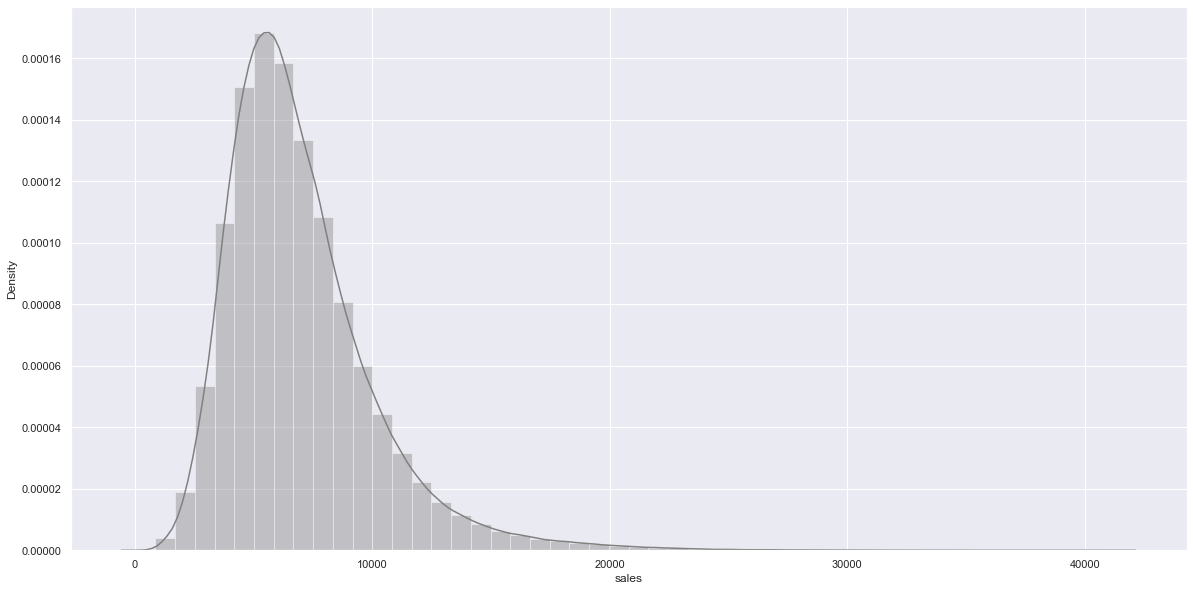

In [17]:
sns.distplot(df4['sales'], color='gray')

#### 4.1.2 Numeric Variables

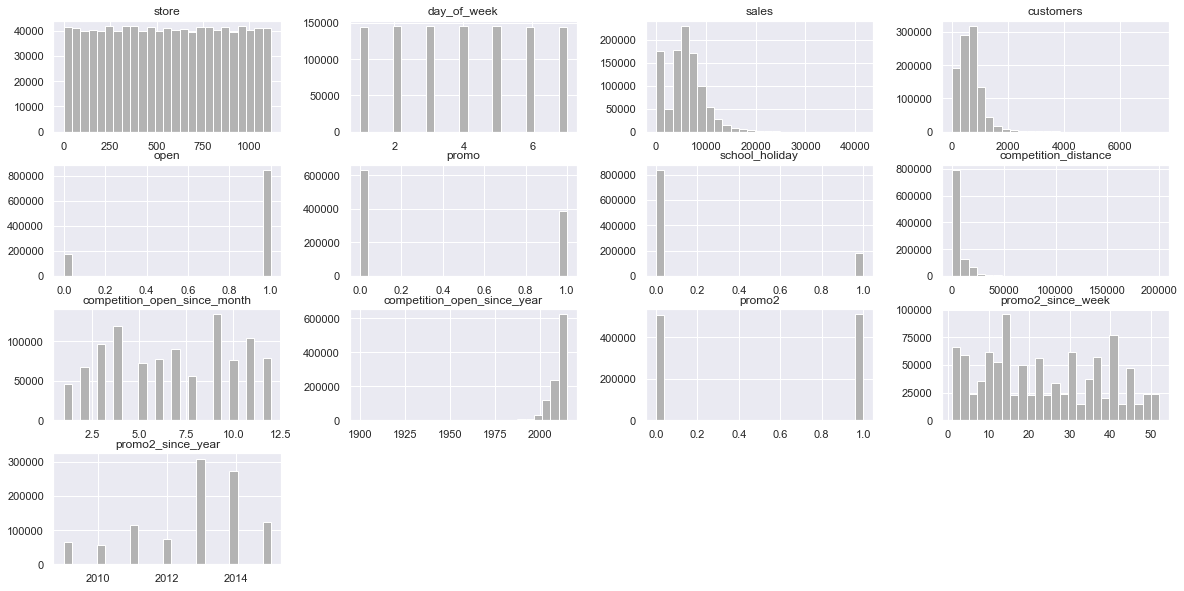

In [19]:
numerical.hist(bins=25, color = ".7");

#### 4.1.3 Categoric Variables

<AxesSubplot:xlabel='sales', ylabel='Density'>

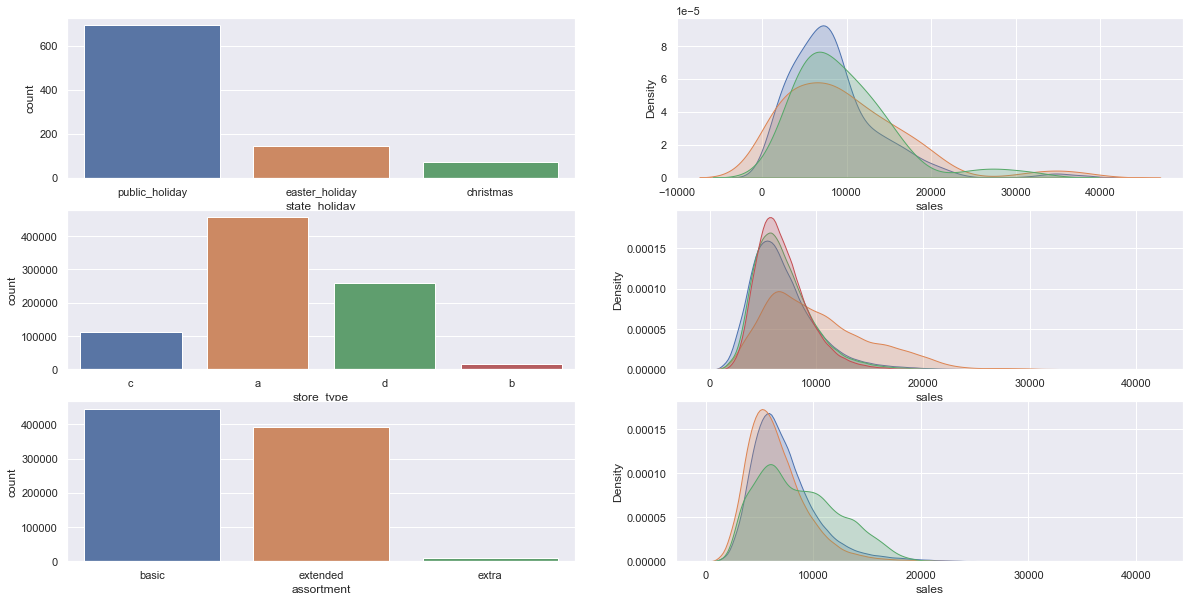

In [18]:
a = df4[df4['state_holiday'] != 'regular_day']

#State holiday
plt.subplot(3,2,1)
sns.countplot(a['state_holiday'])

plt.subplot(3,2,2)
sns.kdeplot( df4[df4['state_holiday'] == 'public_holiday']['sales'], label='public_holiday', shade=True )
sns.kdeplot( df4[df4['state_holiday'] == 'easter_holiday']['sales'], label='easter_holiday', shade=True )
sns.kdeplot( df4[df4['state_holiday'] == 'christmas']['sales'], label='christmas', shade=True )

#Store type
plt.subplot(3,2,3)
sns.countplot(df4['store_type'])

plt.subplot(3,2,4)
sns.kdeplot( df4[df4['store_type']  == 'a']['sales'], label='a', shade=True )
sns.kdeplot( df4[df4['store_type']  == 'b']['sales'], label='b', shade=True )
sns.kdeplot( df4[df4['store_type']  == 'c']['sales'], label='c', shade=True )
sns.kdeplot( df4[df4['store_type']  == 'd']['sales'], label='d', shade=True )

#Assortment
plt.subplot( 3, 2, 5 )
sns.countplot( df4['assortment'] )

plt.subplot( 3, 2, 6 )
sns.kdeplot( df4[df4['assortment'] == 'extended']['sales'], label='extended',shade=True )
sns.kdeplot( df4[df4['assortment'] == 'basic']['sales'], label='basic',shade=True )
sns.kdeplot( df4[df4['assortment'] == 'extra']['sales'], label='extra',shade=True )

## 4.2 Exploring Hypothesis

#### H1 - Stores with the highest assortment are expected sell more, on average
**TRUE - Stores that have extra assortment sell 18% more than extended and, extended assortment sells 10% more than basic assortment**


posx and posy should be finite values
posx and posy should be finite values


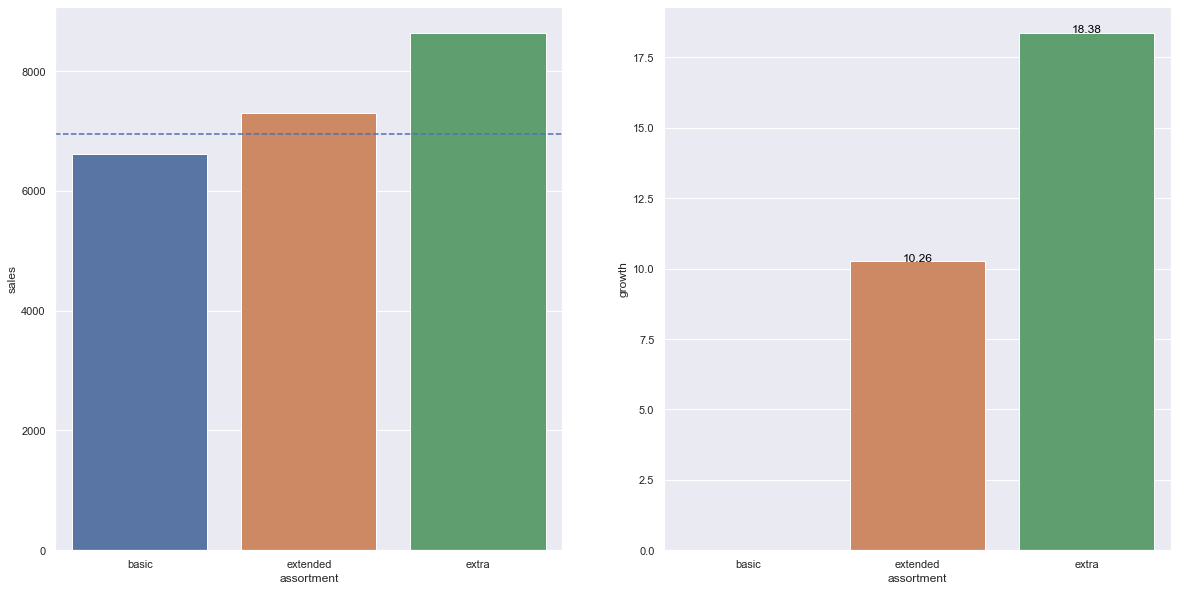

In [21]:
h1 = df4[['assortment','sales']].groupby('assortment').mean().reset_index()

plt.subplot(1,2,1)
sns.barplot(data=h1, x='assortment',y='sales');
plt.axhline(np.mean(df4['sales']),linestyle='--')

#Percentage of growth
plt.subplot(1,2,2)
h1['growth'] = 100*h1['sales'].pct_change()
p = sns.barplot(data=h1,x='assortment',y='growth')
for index,row in h1.iterrows():
    p.text(row.name,row.growth,round(row.growth,2), ha="center", color = 'black')


#### H2 - Stores in promotion are expected to sell more, on average
**TRUE - Stores that have promotion sell 10% more**

posx and posy should be finite values
posx and posy should be finite values


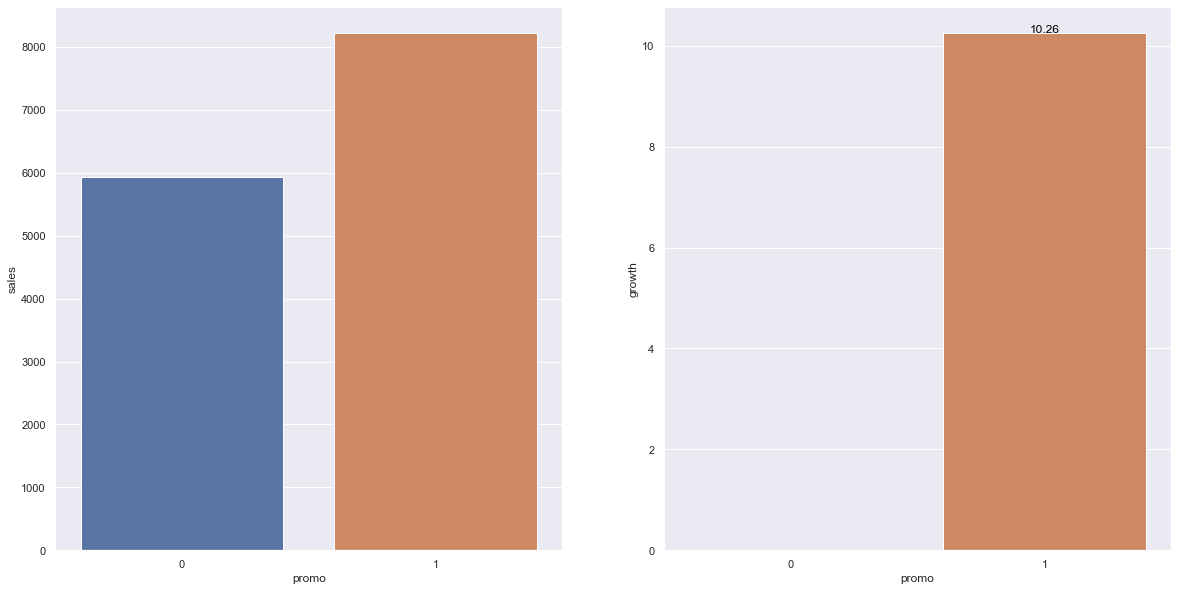

In [22]:
plt.subplot(1,2,1)
h2 = df4[['sales','promo']].groupby('promo').mean().reset_index()
sns.barplot(data=h2, x='promo',y='sales')

#Percentage of growth
plt.subplot(1,2,2)
h2['growth'] = 100*h1['sales'].pct_change()
p = sns.barplot(data=h2,x='promo',y='growth')
for index,row in h2.iterrows():
    p.text(row.name,row.growth,round(row.growth,2), ha="center", color = 'black')
    

#### H3 - Stores with close competitors should sell less, on average.
**FALSE - The distance from the competitor does not significantly influence sales**

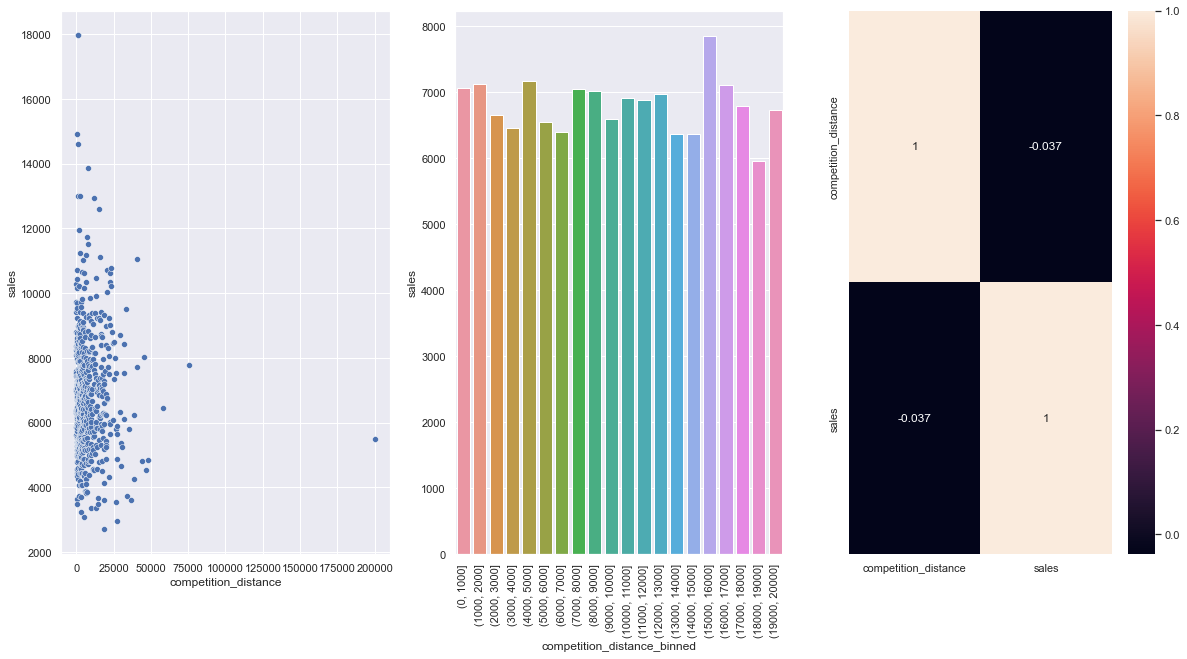

In [23]:
h3 = df4[['sales','competition_distance']].groupby('competition_distance').mean().reset_index()
plt.subplot( 1, 3, 1 )
sns.scatterplot(data=h3,x='competition_distance',y='sales')

plt.subplot( 1, 3, 2)
bins = list( np.arange( 0, 21000, 1000) )
h3['competition_distance_binned'] = pd.cut( h3['competition_distance'],bins=bins )
aux = h3[['sales','competition_distance_binned']].groupby('competition_distance_binned').mean().reset_index()
sns.barplot(data=aux,x='competition_distance_binned',y='sales')
plt.xticks(rotation=90);

plt.subplot( 1, 3, 3)
sns.heatmap( h3.corr( method='pearson' ), annot=True );

#### H4 - Stores should sell more in holidays, on average
**TRUE - The average sales are higher on holidays than regular days, regular days have the lowest average sales**


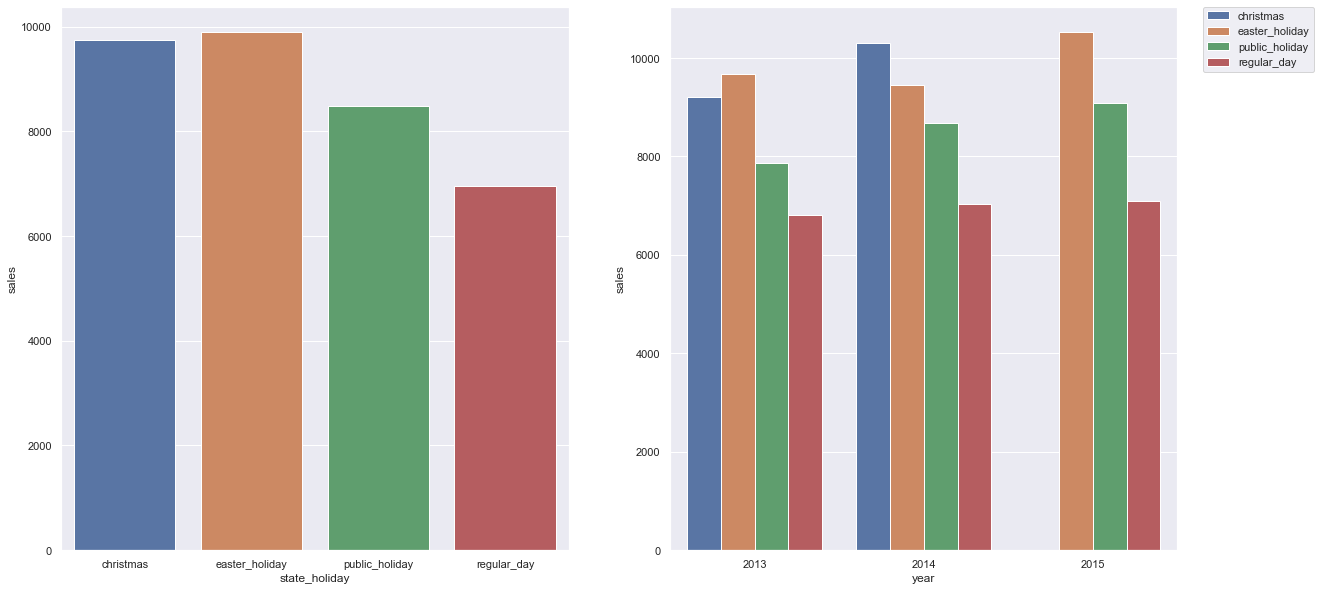

In [24]:
plt.subplot( 1, 2, 1 )
h4 = df4[['sales','state_holiday']].groupby('state_holiday').mean().reset_index()
sns.barplot(data=h4, x="state_holiday",y='sales')

plt.subplot( 1, 2, 2 )
aux = df4[['year', 'state_holiday', 'sales']].groupby( ['year','state_holiday'] ).mean().reset_index()
sns.barplot( x='year', y='sales', hue='state_holiday', data=aux );
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);

#### H5 - Christmas is the best selling holiday
**FALSE - Easter holiday is the holiday that has the highest sales**

posx and posy should be finite values
posx and posy should be finite values


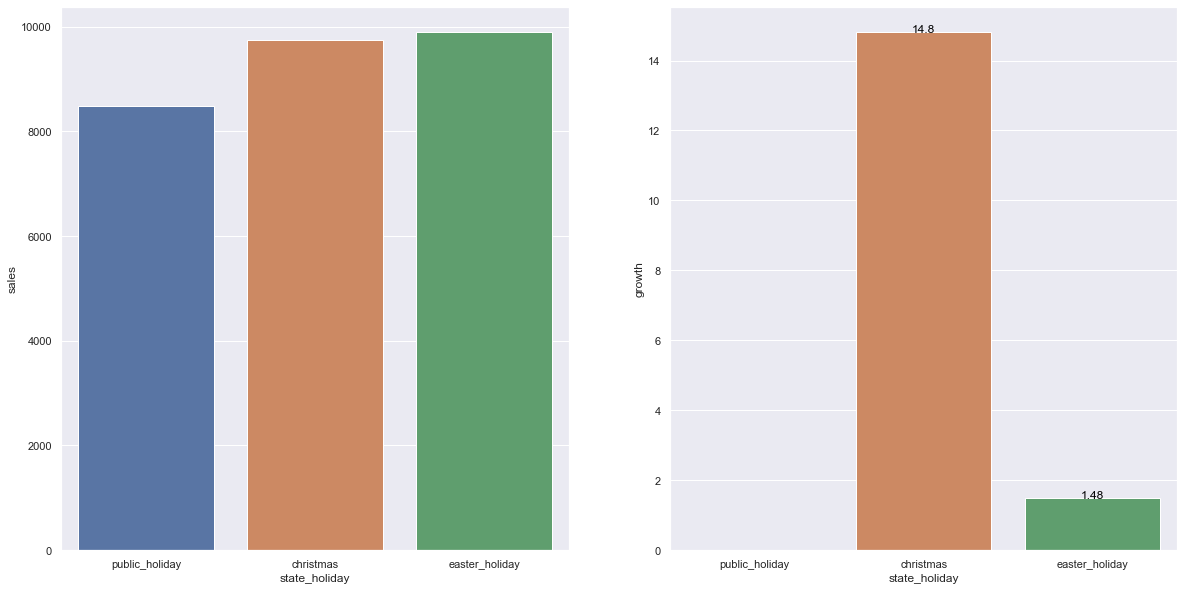

In [25]:
plt.subplot( 1, 2, 1)
h5 = df4[df4['state_holiday'] != 'regular_day'][['state_holiday', 'sales']].groupby('state_holiday').mean().sort_values('sales').reset_index()
sns.barplot(y='sales', x='state_holiday', data=h5 );

plt.subplot( 1, 2, 2)
h5 = df4[df4['state_holiday'] != 'regular_day'][['state_holiday', 'sales']].groupby('state_holiday').mean().sort_values('sales').reset_index()
h5['growth'] = 100*h5['sales'].pct_change()
p = sns.barplot(y='growth', x='state_holiday', data=h5 );
for index, row in h5.iterrows():
    p.text(row.name,row.growth,round(row.growth,2), ha="center", color = 'black')
    


#### H6 - Stores with more time of promotion should sell more
**FALSE - Stores with more consecutive promotions sell less**

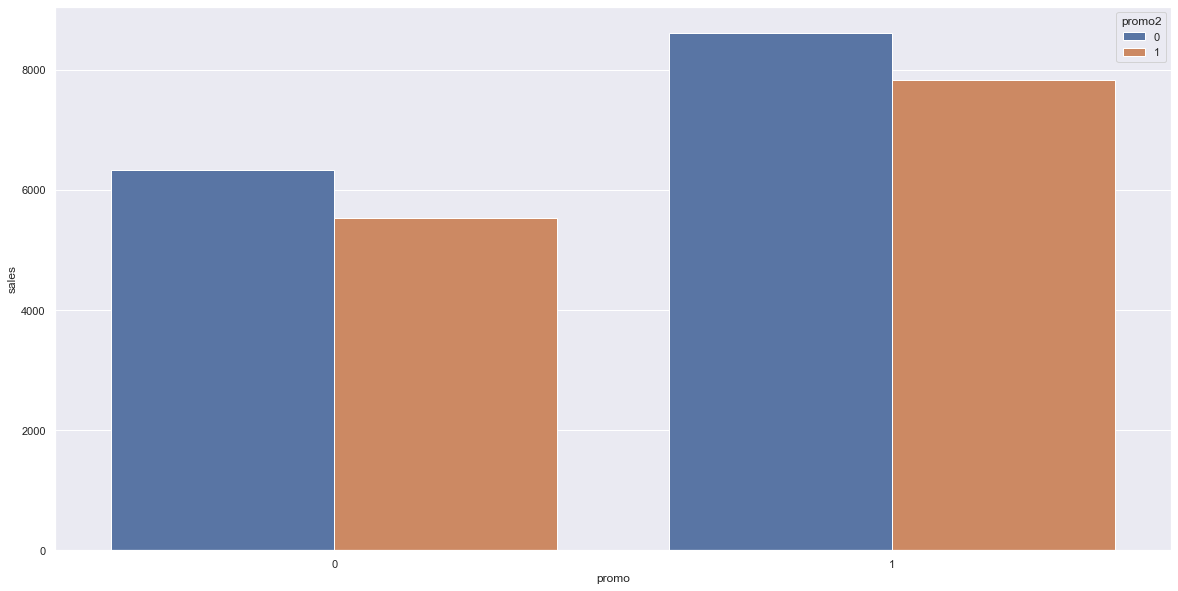

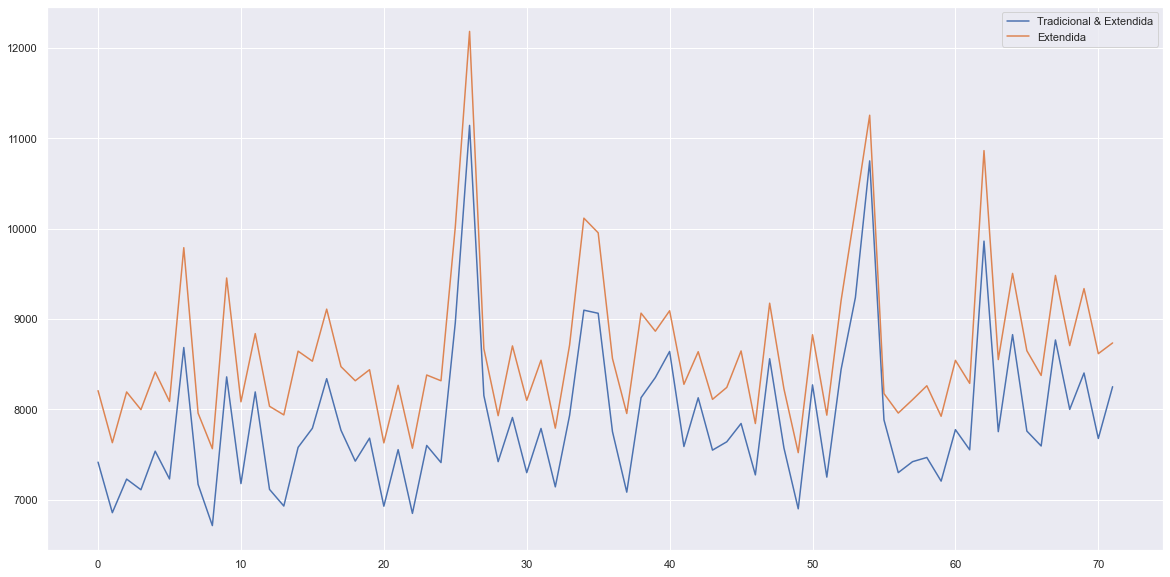

In [26]:
h6 = df4[['sales','promo','promo2']].groupby(['promo','promo2']).mean().reset_index()
sns.barplot(data=h6,x='promo',y='sales', hue='promo2')

aux = df4[( df4['promo'] == 1 ) & ( df4['promo2'] == 1 )][['year_week','sales']].groupby( 'year_week' ).mean().reset_index()
ax = aux.plot()
aux1 = df4[( df4['promo'] == 1 ) & ( df4['promo2'] == 0 )][['year_week','sales']].groupby( 'year_week' ).mean().reset_index()
aux1.plot(ax=ax )
ax.legend( labels=['Tradicional & Extendida', 'Extendida']);

#### H7 - Stores with longer competitors are expected to sell more.
**FALSE - Stores that have competitior that have recently opened sell more, there is a drop in sales over time**

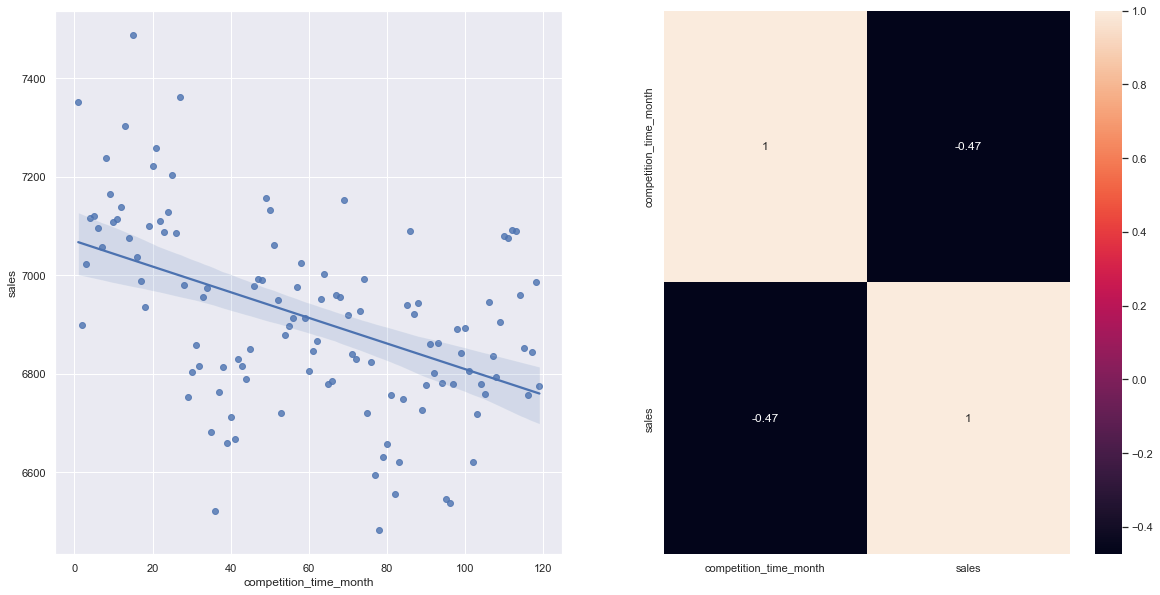

In [27]:
plt.subplot( 1, 2, 1 )
h7 = df4[['competition_time_month', 'sales']].groupby('competition_time_month' ).mean().reset_index()
aux = h7[( h7['competition_time_month'] < 120 ) & (h7['competition_time_month'] > 0 )]
sns.regplot( x='competition_time_month', y='sales', data=aux );
plt.subplot( 1, 2, 2 )
x = sns.heatmap( aux.corr( method='pearson'), annot=True );

#### H8 - Stores sells more in the second semester, on average
**TRUE - Stores sell 2.7% more in the second semester**

<AxesSubplot:xlabel='month', ylabel='sales'>

posx and posy should be finite values
posx and posy should be finite values


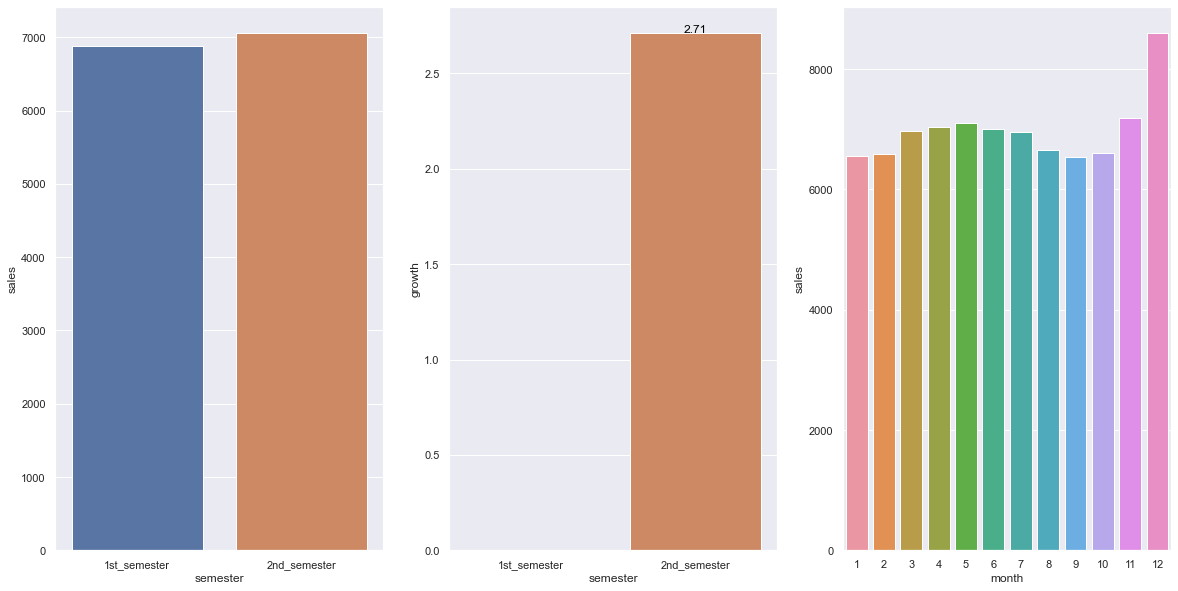

In [28]:
plt.subplot(1,3,1)
h8 = df4[['sales','semester']].groupby('semester').mean().reset_index()
sns.barplot(data=h8,x='semester',y='sales')

plt.subplot(1,3,2)
h8 = df4[['sales','semester']].groupby('semester').mean().reset_index()
h8['growth'] = 100*h8['sales'].pct_change()

p = sns.barplot(data=h8,x='semester',y='growth')
for index, row in h8.iterrows():
    p.text(row.name,row.growth,round(row.growth,2), ha='center',color='black')

plt.subplot(1,3,3)
aux = df4[['sales','month']].groupby('month').mean().reset_index()
sns.barplot(data=aux,x='month',y='sales')

#### H9 - Stores should sell more over the years 
**TRUE - Stores sell about 2% more over year, on average**

posx and posy should be finite values
posx and posy should be finite values


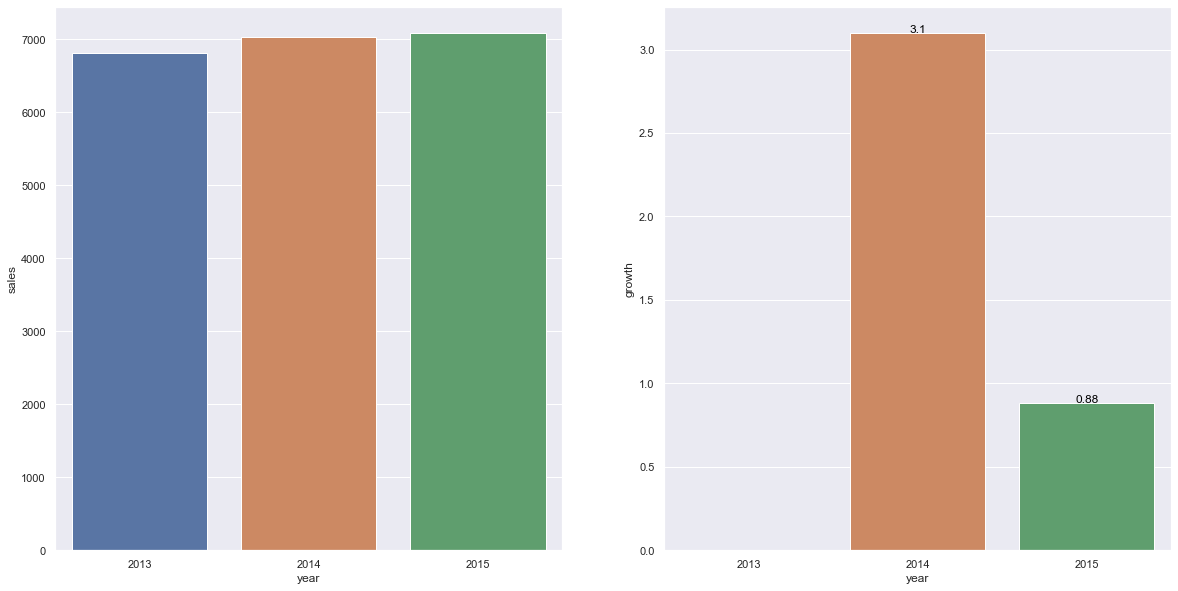

In [29]:
plt.subplot(1,2,1)
h9 = df4[['sales','year']].groupby('year').mean().reset_index()
sns.barplot(data=h9,x='year',y='sales')


plt.subplot(1,2,2)
h9 = df4[['sales','year']].groupby('year').mean().reset_index()
h9['growth'] = 100*h9['sales'].pct_change()

p = sns.barplot(data=h9,x='year',y='growth')
for index, row in h9.iterrows():
    p.text(row.name,row.growth,round(row.growth,2), ha='center',color='black')

#### H10 - Stores with competitors open for less time should sell less
**TRUE - Stores sell less on weekends**

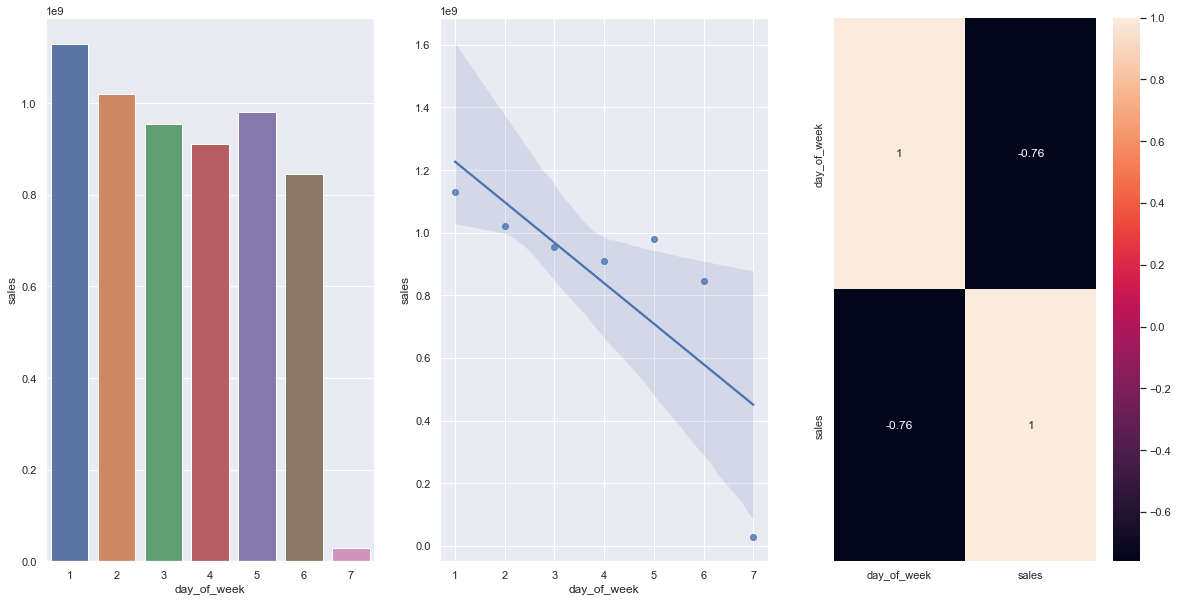

In [30]:
h10 = df4[['day_of_week', 'sales']].groupby( 'day_of_week' ).sum().reset_index()
plt.subplot( 1, 3, 1 )
sns.barplot( x='day_of_week', y='sales', data=h10 );
plt.subplot( 1, 3, 2 )
sns.regplot( x='day_of_week', y='sales', data=h10 );
plt.subplot( 1, 3, 3 )
sns.heatmap( h10.corr( method='pearson' ), annot=True );


## 4.3 Correlations

#### Numeric

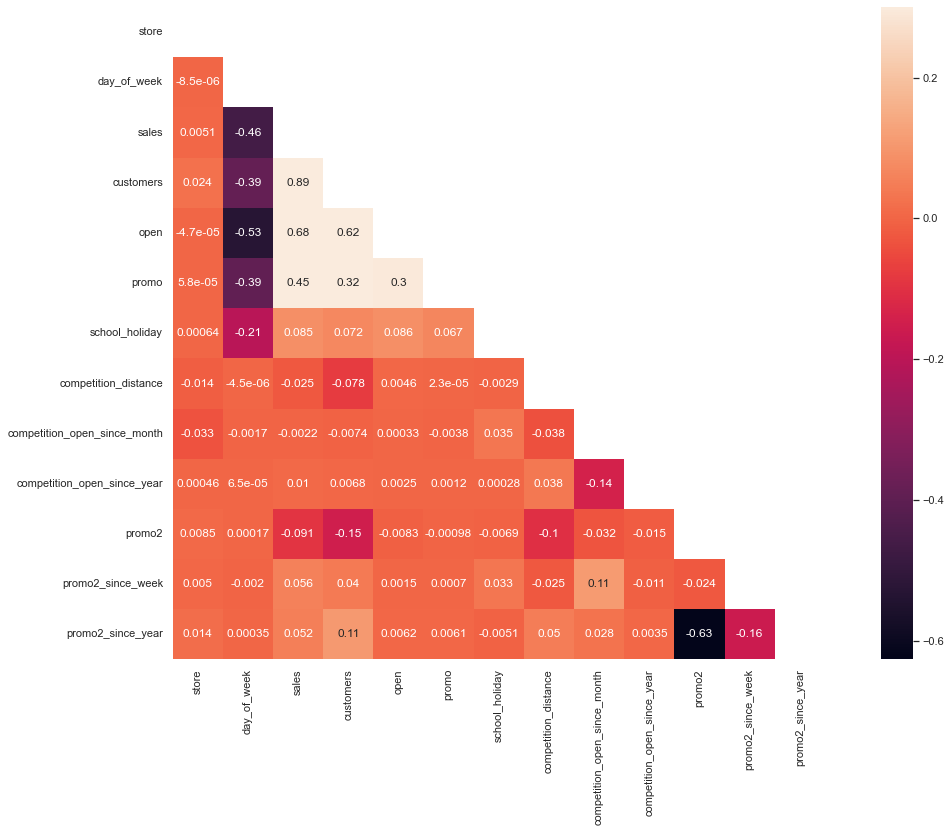

In [19]:
corr = numerical.corr(method='pearson')
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(20,12))
    ax = sns.heatmap(corr, mask=mask, vmax=.3, square=True,annot=True)

#### Categoric

<AxesSubplot:>

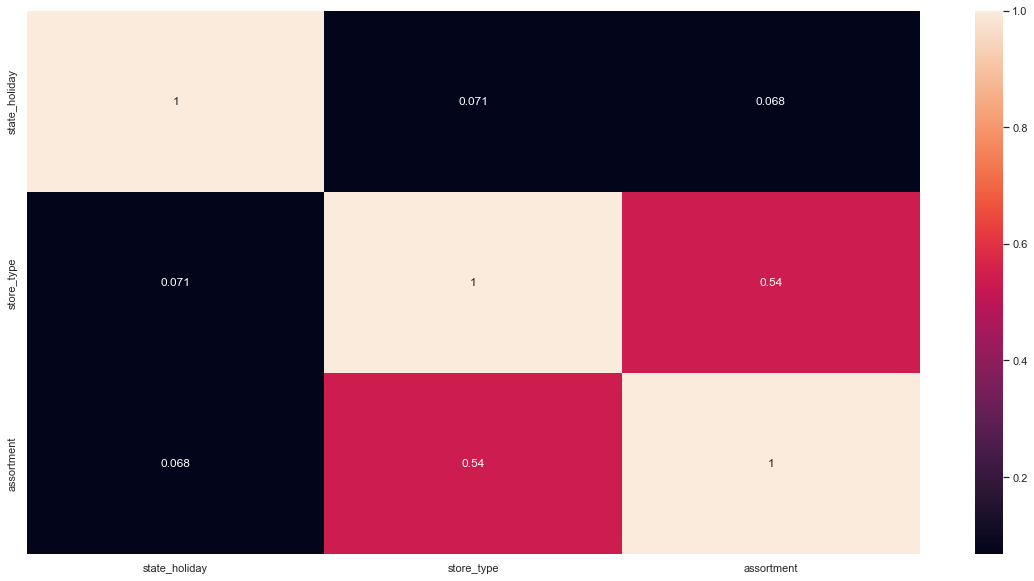

In [20]:
# only categorical data
a = df4.select_dtypes( include='object' )
# Calculate cramer V
a1 = cramer_v( a['state_holiday'], a['state_holiday'] )
a2 = cramer_v( a['state_holiday'], a['store_type'] )
a3 = cramer_v( a['state_holiday'], a['assortment'] )
a4 = cramer_v( a['store_type'], a['state_holiday'] )
a5 = cramer_v( a['store_type'], a['store_type'] )
a6 = cramer_v( a['store_type'], a['assortment'] )
a7 = cramer_v( a['assortment'], a['state_holiday'] )
a8 = cramer_v( a['assortment'], a['store_type'] )
a9 = cramer_v( a['assortment'], a['assortment'] )

# Final dataset
d = pd.DataFrame( {'state_holiday': [a1, a2, a3],'store_type': [a4, a5, a6],'assortment': [a7, a8, a9] })
d = d.set_index( d.columns )
sns.heatmap( d, annot=True )





# 5.0 Data Preparation


In [20]:
df5 = df4.copy()

## 5.1 Rescaling

In [21]:
mms = MinMaxScaler()
rs = RobustScaler()

summary(df5)


,Min,Max,Range,Median,Mean,Standard Deviation,Skewness,Kurtosis
store,1.0,1115.0,1114.0,558.0,558.421374,321.730671,0.000426,-1.198836
day_of_week,1.0,7.0,6.0,3.0,3.520350,1.723711,0.019310,-1.259347
sales,46.0,41551.0,41505.0,6369.0,6955.959134,3103.813677,1.594929,4.854027
promo,0.0,1.0,1.0,0.0,0.446356,0.497114,0.215824,-1.953425
school_holiday,0.0,1.0,1.0,0.0,0.193578,0.395102,1.551109,0.405939
competition_distance,20.0,200000.0,199980.0,2330.0,5961.827515,12592.173650,10.134908,145.288658
competition_open_since_month,1.0,12.0,11.0,7.0,6.787355,3.309915,-0.048451,-1.231875
competition_open_since_year,1900.0,2015.0,115.0,2012.0,2010.331102,5.502625,-7.217323,123.903078
promo2,0.0,1.0,1.0,0.0,0.498670,0.499998,0.005320,-1.999976
promo2_since_week,1.0,52.0,51.0,22.0,23.629083,14.288306,0.170399,-1.194815


#### 5.1.1 Robust Scaler

In [144]:
#competition distance
df5['competition_distance'] = rs.fit_transform(df5[['competition_distance']].values)
pickle.dump( rs, open( 'parameter\\competition_distance_scaler.pkl', 'wb') )

#competition_time_month
df5['competition_time_month'] = rs.fit_transform(df5[['competition_time_month']].values)
pickle.dump( rs, open( 'parameter\\competition_time_month_scaler.pkl', 'wb') )


#### 5.1.2 Min-Max Scaler

In [145]:
#promo_time_week
df5['promo_time_week'] = mms.fit_transform( df5[['promo_time_week']].values )
pickle.dump( mms, open( 'parameter\\promo_time_week_scaler.pkl', 'wb') )

#year
df5['year'] = mms.fit_transform( df5[['year']].values )
pickle.dump( mms, open( 'parameter\\year_scaler.pkl', 'wb') )


## 5.3 Transformation

In [25]:
df5.select_dtypes(include='object')

,state_holiday,store_type,assortment,semester,year_week
0,regular_day,c,basic,2nd_semester,2015-30
1,regular_day,a,basic,2nd_semester,2015-30
2,regular_day,a,basic,2nd_semester,2015-30
3,regular_day,c,extended,2nd_semester,2015-30
4,regular_day,a,basic,2nd_semester,2015-30
...,...,...,...,...,...
1016776,public_holiday,b,basic,1st_semester,2013-00
1016827,public_holiday,b,extra,1st_semester,2013-00
1016863,public_holiday,b,extra,1st_semester,2013-00
1017042,public_holiday,b,extra,1st_semester,2013-00


### Enconding

#### 5.3.1 One-Hot-Enconding

In [24]:
#state holiday 
df5 = pd.get_dummies( df5, prefix=['state_holiday'], columns=['state_holiday'] )

#### 5.3.2 Label Enconding

In [146]:
#store type
le = LabelEncoder()
df5['store_type'] = le.fit_transform( df5['store_type'] )
pickle.dump( le, open( 'parameter\\store_type_scaler.pkl', 'wb') )

#### 5.3.3 Ordinal Encoding

In [26]:
#assortment
assortment_dict = {'basic': 1, 'extra': 2, 'extended': 3}
df5['assortment'] = df5['assortment'].map( assortment_dict )

#### 5.3.4 Response Variable Transformation

In [27]:
df5['sales'] = np.log1p( df5['sales'] )

#### 5.3.5 Nature Transformation

In [28]:
# day of week
df5['day_of_week_sin'] = df5['day_of_week'].apply( lambda x: np.sin( x * ( 2. *np.pi/7 ) ) )
df5['day_of_week_cos'] = df5['day_of_week'].apply( lambda x: np.cos( x * ( 2. *np.pi/7 ) ) )
# month
df5['month_sin'] = df5['month'].apply( lambda x: np.sin( x * ( 2. * np.pi/12 )) )
df5['month_cos'] = df5['month'].apply( lambda x: np.cos( x * ( 2. * np.pi/12 )) )
# day
df5['day_sin'] = df5['day'].apply( lambda x: np.sin( x * ( 2. * np.pi/30 ) ) )
df5['day_cos'] = df5['day'].apply( lambda x: np.cos( x * ( 2. * np.pi/30 ) ) )
# week of year
df5['week_of_year_sin'] = df5['week_of_year'].apply( lambda x: np.sin( x * ( 2* np.pi/52 ) ) )
df5['week_of_year_cos'] = df5['week_of_year'].apply( lambda x: np.cos( x * ( 2* np.pi/52 ) ) )

# 6.0 Feature Selection

In [29]:
df6 = df5.copy()
df6

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,...,state_holiday_public_holiday,state_holiday_regular_day,day_of_week_sin,day_of_week_cos,month_sin,month_cos,day_sin,day_cos,week_of_year_sin,week_of_year_cos
0,1,5,2015-07-31,8.568646,1,1,2,1,-0.170968,9,...,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
1,2,5,2015-07-31,8.710290,1,1,0,1,-0.283871,11,...,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
2,3,5,2015-07-31,9.025816,1,1,0,1,1.903226,12,...,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
3,4,5,2015-07-31,9.546527,1,1,2,3,-0.275806,9,...,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
4,5,5,2015-07-31,8.481151,1,1,0,1,4.448387,4,...,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1016776,682,2,2013-01-01,8.124447,0,1,1,1,-0.351613,9,...,1,0,0.974928,-0.222521,0.5,0.866025,0.207912,0.978148,0.120537,0.992709
1016827,733,2,2013-01-01,9.284148,0,1,1,2,-0.237097,10,...,1,0,0.974928,-0.222521,0.5,0.866025,0.207912,0.978148,0.120537,0.992709
1016863,769,2,2013-01-01,8.524367,0,1,1,2,-0.240323,1,...,1,0,0.974928,-0.222521,0.5,0.866025,0.207912,0.978148,0.120537,0.992709
1017042,948,2,2013-01-01,8.410053,0,1,1,2,-0.145161,1,...,1,0,0.974928,-0.222521,0.5,0.866025,0.207912,0.978148,0.120537,0.992709


## 6.1 Split dataframe into training and test dataset

In [30]:
#discarding features that gave rise to new transformed feature and datetime features
cols_drop = ['week_of_year', 'day', 'month', 'day_of_week', 'promo_since','competition_since', 'year_week' ,'semester']
df6 = df6.drop( cols_drop, axis=1 )

In [31]:
#Training set
X_train = df6[df6['date'] < (df6['date'].max() - datetime.timedelta(days=6*7)).strftime('%Y-%m-%d')]
y_train = X_train['sales']

#Test set
X_test = df6[df6['date'] >= (df6['date'].max() - datetime.timedelta(days=6*7)).strftime('%Y-%m-%d')]
y_test = X_test['sales']

In [35]:
print( 'Training Min Date: {}'.format( X_train['date'].min() ) )
print( 'Training Max Date: {}'.format( X_train['date'].max() ) )

print( '\nTest Min Date: {}'.format( X_test['date'].min() ) )
print( 'Test Max Date: {}'.format( X_test['date'].max() ) )

Training Min Date: 2013-01-01 00:00:00
Training Max Date: 2015-06-18 00:00:00

Test Min Date: 2015-06-19 00:00:00
Test Max Date: 2015-07-31 00:00:00


## 6.2 Boruta as Feature Selector

In [135]:
# training and test dataset for Boruta
## Removing 'sales' and 'date' from training test
# X_train_n = X_train.drop(['sales','date'], axis=1).values
# y_train_n = y_train.values.ravel()

## define RandomForestRegressor
# rf = RandomForestRegressor( n_jobs=-1 )

## define Boruta
# boruta = BorutaPy( rf, n_estimators='auto', verbose=2, random_state=42 ).fit(X_train_n, y_train_n )

### 6.2.1. Best Features from Boruta

In [ ]:
#cols_selected = boruta.support_.tolist()
#
## best features
#X_train_fs = X_train.drop( ['date', 'sales'], axis=1 )
#cols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns.to_list()
#
## not selected boruta
#cols_not_selected_boruta = list( np.setdiff1d( X_train_fs.columns,cols_selected_boruta ) )

## 6.3 Manual Feature Selection

In [32]:
cols_selected_boruta = ['store',
                        'promo',
                        'store_type',
                        'assortment',
                        'competition_distance',
                        'competition_open_since_month',
                        'competition_open_since_year',
                        'promo2',
                        'promo2_since_week',
                        'promo2_since_year',
                        'competition_time_month',
                        'promo_time_week',
                        'day_of_week_sin',
                        'day_of_week_cos',
                        'month_sin',
                        'month_cos',
                        'day_sin',
                        'day_cos',
                        'week_of_year_sin',
                        'week_of_year_cos']

# columns to add
feat_to_add = ['date', 'sales']
cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend( feat_to_add )

# 7.0 Machine Learning Modeling

In [4]:
#Training set with features selected by boruta
x_train = X_train[cols_selected_boruta]
x_test = X_test[cols_selected_boruta]

#Time Series Data Preparation
x_training = X_train[ cols_selected_boruta_full ]

NameError: name 'X_train' is not defined

## 7.1 Average Model

In [43]:
aux1 = x_test.copy()
aux1['sales'] = y_test.copy()

# prediction
aux2 = aux1[['store', 'sales']].groupby( 'store' ).mean().reset_index().rename(columns={'sales': 'predictions'} )
aux1 = pd.merge( aux1, aux2, how='left', on='store' )
yhat = aux1['predictions']

# performance
baseline_result = ml_error( 'Average Model', np.expm1(y_test), np.expm1(yhat))
baseline_result


,Model Name,MAE,MAPE,RMSE
0,Average Model,2878.541458,0.455051,1835.135542


## 7.2 Linear Regression Model

In [44]:
#model
lr = LinearRegression().fit(x_train,y_train)

# prediction
yhat_lr = lr.predict( x_test )

lr_result = ml_error( 'Linear Regression', np.expm1( y_test ), np.expm1(yhat_lr ))
lr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,1867.089774,0.292694,2671.049215


#### 7.2.1 CrossValidation

In [45]:
lr_result_cv = cross_validation( x_training, 5, 'Linear Regression', lr,verbose=False )
lr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2081.73 +/- 295.63,0.3 +/- 0.02,2952.52 +/- 468.37


## 7.3. Linear Regression Regularized Model - Lasso

In [46]:
#model
lrr = Lasso( alpha=0.01 ).fit(x_train, y_train)

# prediction
yhat = lrr.predict(x_test)

# performance
lrr_result = ml_error('Linear Regression - Lasso', np.expm1(y_test), np.expm1( yhat))
lrr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression - Lasso,1889.240262,0.294398,2720.682747


#### 7.3.1 CrossValidation

In [47]:
lrr_result_cv = cross_validation( x_training, 5, 'Lasso ', lrr, verbose=False )
lrr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Lasso,2112.89 +/- 342.63,0.29 +/- 0.01,3048.46 +/- 508.15


## 7.4 Random Forest Regressor

In [38]:
model
rf = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=42).fit(x_train, y_train)

# prediction
yhat_rf = rf.predict(x_test)

#performance
rf_result = ml_error('Random Forest Regressor', np.expm1( y_test ), np.expm1(yhat_rf))
rf_result

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,679.52803,0.099892,1011.010177


In [39]:
rf_result_cv = cross_validation( x_training, 5, 'Random Forest Regressor', rf,verbose=True )
rf_result_cv


KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1


,Model Name,MAE CV,MAPE CV,RMSE CV
0,Random Forest Regressor,836.28 +/- 216.97,0.12 +/- 0.02,1253.85 +/- 316.02


## 7.5 Compare Models Performance

## 7.5.1 Single Performance 

In [49]:
modelling_result = pd.concat([baseline_result, lr_result, lrr_result, rf_result])
modelling_result.sort_values ('RMSE')

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,679.528030,0.099892,1011.010177
0,Average Model,2878.541458,0.455051,1835.135542
0,Linear Regression,1867.089774,0.292694,2671.049215
0,Linear Regression - Lasso,1889.240262,0.294398,2720.682747


## 7.5.2 Cross Validation Performance 

In [51]:
modelling_result_cv = pd.concat([lr_result_cv, lrr_result_cv, rf_result_cv])
modelling_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2081.73 +/- 295.63,0.3 +/- 0.02,2952.52 +/- 468.37
0,Lasso,2112.89 +/- 342.63,0.29 +/- 0.01,3048.46 +/- 508.15
0,Random Forest Regressor,836.28 +/- 216.97,0.12 +/- 0.02,1253.85 +/- 316.02


# 8.0 HYPERPARAMETER FINE TUNING

## 8.1 Random Search

In [65]:
# params = {'bootstrap': [True, False],
#          'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
#          'max_features': ['auto', 'sqrt'],
#          'min_samples_leaf': [1, 2, 4],
#          'min_samples_split': [2, 5, 10],
#          'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}



In [71]:
# # Use the random grid to search for best hyperparameters
# # First create the base model to tune
# rf = RandomForestRegressor()
# # Random search of parameters, using 3 fold cross validation, 
# # search across 100 different combinations, and use all available cores
# rf_random = RandomizedSearchCV(estimator = rf, param_distributions = params, n_iter = 12, cv = 3, verbose=2, random_state=42, n_jobs = -1)

# # Fit the random search model
# rf_random.fit(x_train, y_train)

# #Best parameters
#rf_random.best_params_

## 8.2 Final Model

In [78]:
param_tuned = {'n_estimators': 1000,
          'min_samples_split': 10,
          'min_samples_leaf': 4,
          'max_features': 'auto',
          'max_depth': 50,
          'bootstrap': True}


rf_tuned = RandomForestRegressor(n_jobs=-1,
                                 min_samples_split=param_tuned['min_samples_split'],
                                 min_samples_leaf=param_tuned['min_samples_leaf'],
                                 max_features=param_tuned['max_features'],
                                 max_depth=param_tuned['max_depth'],
                                 bootstrap=param_tuned['bootstrap']).fit(x_train, y_train)
                                        
yhat_rf_tuned = rf_tuned.predict(x_test)
rf_tuned_result = ml_error( 'Random Forest Regressor', np.expm1(y_test), np.expm1(yhat_rf_tuned ) )
rf_tuned_result

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,676.552722,0.099234,1013.124493


In [79]:
mpe = mean_percentage_error( np.expm1( y_test ), np.expm1( yhat_rf_tuned ) )
mpe


-0.017718413002253925

# 9.0 Error Interpretation

In [5]:
df9 = X_test[ cols_selected_boruta_full ]
# rescale
df9['sales'] = np.expm1( df9['sales'] )
df9['predictions'] = np.expm1( yhat_rf_tuned )

NameError: name 'X_test' is not defined

## 9.1 Business Performance

In [119]:
#sum of predictions
df91 = df9[['store', 'predictions']].groupby( 'store' ).mean().reset_index()

# MAE and MAPE
df9_aux1 = df9[['store', 'sales', 'predictions']].groupby( 'store' ).apply(lambda x: mean_absolute_error( x['sales'], x['predictions'] ) ).reset_index().rename( columns={0:'MAE'})
df9_aux2 = df9[['store', 'sales', 'predictions']].groupby( 'store' ).apply(lambda x: mean_absolute_percentage_error( x['sales'], x['predictions'] ) ).reset_index().rename( columns={0:'MAPE'})

# Merge
df9_aux3 = pd.merge( df9_aux1, df9_aux2, how='inner', on='store' )
df92 = pd.merge( df91, df9_aux3, how='inner', on='store' )

# Scenarios
df92['worst_scenario'] = (df92['predictions'] - df92['MAE'])*6*7
df92['best_scenario'] = (df92['predictions'] + df92['MAE'])*6*7

# order columns
df92 = df92[['store', 'predictions', 'worst_scenario', 'best_scenario', 'MAE','MAPE']]
df92

,store,predictions,worst_scenario,best_scenario,MAE,MAPE
0,1,4472.982240,175464.729528,200265.778663,295.250585,0.068457
1,2,4895.860058,188249.490489,223002.754383,413.729332,0.079711
2,3,7143.763905,274212.712259,325863.455799,614.889804,0.087959
3,4,9488.661804,366267.445265,430780.146263,768.008345,0.073177
4,5,4672.477072,182273.495566,210214.578509,332.631940,0.078213
...,...,...,...,...,...,...
1110,1111,4914.687021,179151.032702,233682.677046,649.186242,0.143013
1111,1112,9256.051273,347442.163011,430066.143894,983.618820,0.125056
1112,1113,6628.220997,252931.071643,303839.492138,606.052625,0.097087
1113,1114,21125.413722,800139.377002,974395.375681,2074.476175,0.086853


In [116]:
df92.sort_values( 'MAPE', ascending=False ).head()

,store,predictions,worst_scenario,best_scenario,MAE,MAPE
291,292,5706.674949,91452.804544,387907.891153,3529.227222,0.605392
908,909,10513.258469,144981.273466,738132.437896,7061.323386,0.476744
549,550,6903.650394,218346.648649,361559.984469,1704.920665,0.344712
875,876,9214.511315,222029.050287,551989.900145,3928.105355,0.303367
721,722,9521.673536,317038.702703,482781.874342,1973.132996,0.266351


<AxesSubplot:xlabel='store', ylabel='MAPE'>

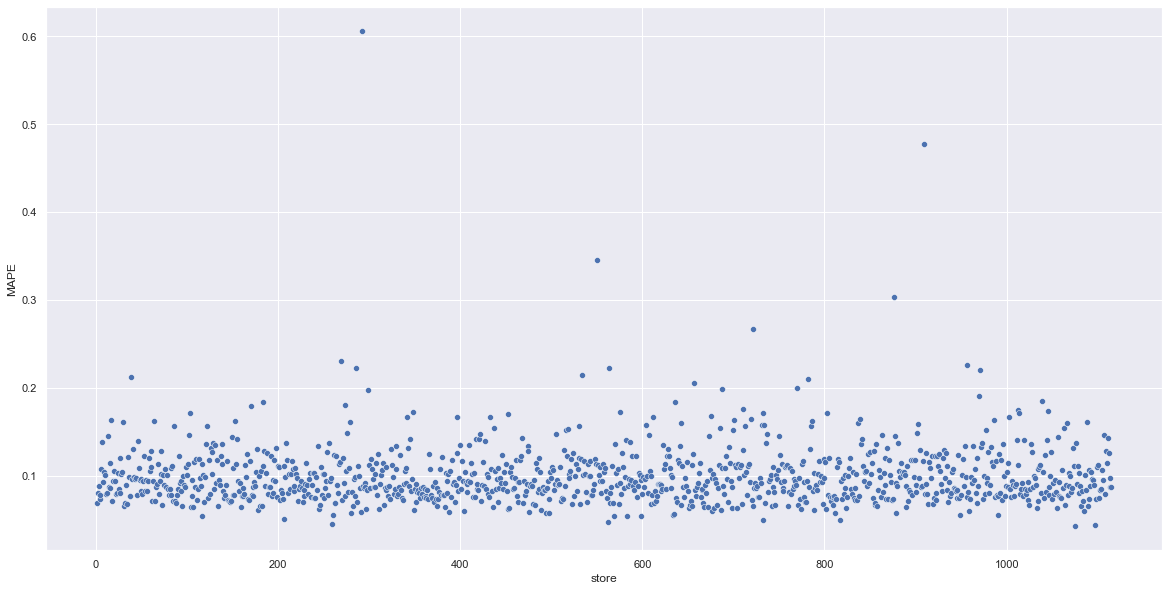

In [117]:
sns.scatterplot( x='store', y='MAPE', data=df92 )

## 9.2 Total Performance

In [8]:
df92['next_six'] = df92['predictions']*6*7
df93 = df92[['next_six', 'worst_scenario', 'best_scenario']].apply( lambda x: np.sum(x), axis=0 ).reset_index().rename( columns={'index': 'Scenario', 0:'Values'} )
df93['Values'] = df93['Values'].map( '€{:,.2f}'.format )
df93

NameError: name 'df92' is not defined

## 9.3 Machine Learning Performance

In [132]:
df9['residual'] = df9['sales'] - df9['predictions']
df9['residual_rate'] = df9['predictions'] / df9['sales']

<AxesSubplot:xlabel='predictions', ylabel='residual'>

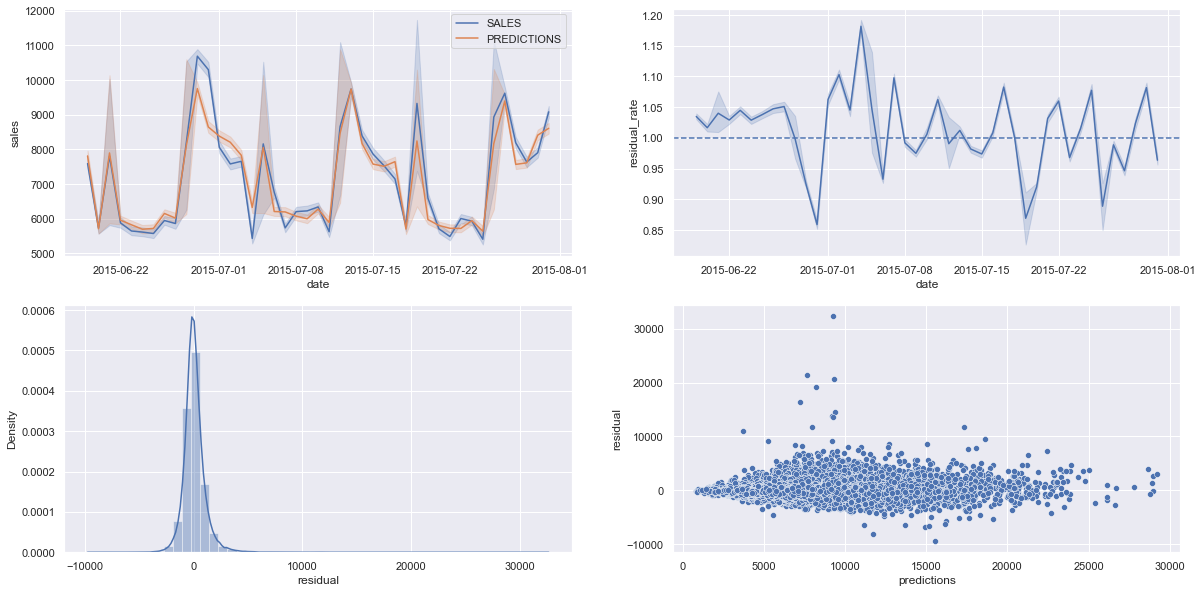

In [133]:
plt.subplot( 2, 2, 1 )
sns.lineplot( x='date', y='sales', data=df9, label='SALES')
sns.lineplot( x='date', y='predictions', data=df9, label='PREDICTIONS')

plt.subplot( 2, 2, 2 )
sns.lineplot( x='date', y='residual_rate', data=df9)
plt.axhline( 1, linestyle='--')

plt.subplot( 2, 2, 3 )
sns.distplot(df9['residual'])

plt.subplot( 2, 2, 4 )
sns.scatterplot(df9['predictions'], df9['residual'])

# 10.0 Deploy Model to Production

In [9]:
#Saving the ML model
pickle.dump(rf_tuned, open('C:\\Users\\mathe\\OneDrive\\Documentos\\Pharmaceutical_Sales\\model_pharmaceutical.pkl', 'wb' ))

NameError: name 'rf_tuned' is not defined

## 10.1 Pharmaceutical Class

In [ ]:
import pickle
import inflection
import math
import datetime
import pandas as pd
import numpy  as np

class Pharmaceutical(object):
    def __init__(self):
        self.home_path='C:\\Users\\mathe\\OneDrive\\Documentos\\Pharmaceutical_Sales\\'
        self.competition_distance_scaler   = pickle.load(open(self.home_path + 'parameter/competition_distance_scaler.pkl', 'rb'))
        self.competition_time_month_scaler = pickle.load(open(self.home_path + 'parameter/competition_time_month_scaler.pkl', 'rb'))
        self.promo_time_week_scaler        = pickle.load(open(self.home_path + 'parameter/promo_time_week_scaler.pkl', 'rb'))
        self.year_scaler                   = pickle.load(open(self.home_path + 'parameter/year_scaler.pkl', 'rb'))
        self.store_type_scaler             = pickle.load(open(self.home_path + 'parameter/store_type_scaler.pkl', 'rb'))
        
    def data_cleaning(self,df):
        #Rename columns - snake case
        cols_camelcase = list(df.columns)
        snake_case = lambda x: inflection.underscore(x)
        cols_snake_case = list(map(snake_case,cols_camelcase))
        
        df.columns = cols_snake_case
        
        #Converting variable 'date' to type datetime
        df['date'] = pd.to_datetime(df['date'])
        
        #Repalcing 0 with '0'
        df['state_holiday'] = df['state_holiday'].replace(0,'0')

        # Replacing NA with a very high distance == no near competition 
        df['competition_distance'] = df['competition_distance'].apply(lambda x: 200000.0 if math.isnan(x) else x) 

        # Replacing NA with months == if diference between 'month store' and 'month open' equal zero, no competition open since month
        df['competition_open_since_month'] = df.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis=1)

        # Replacing NA with year == if diference between 'year store' and 'year open' equal zero, no competition open since year
        df['competition_open_since_year'] = df.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis=1)

        # Replacing NA with week == if diference between 'week store' and 'week since' equal zero, no promo participate since week
        df['promo2_since_week'] = df.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis=1)

        # Replacing NA with year == if diference between 'year store' and 'year since' equal zero, no promo participate since year
        df['promo2_since_year'] = df.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis=1)

        # Replacing NA with 0 = no promo
        df['promo_interval'] = df['promo_interval'].fillna(0)
        
        #Changing data type
        # competiton as int64
        df['competition_open_since_month'] = np.int64(df['competition_open_since_month'])
        df['competition_open_since_year'] = np.int64(df['competition_open_since_year'])

        # promo2 as int64
        df['promo2_since_week'] = np.int64(df['promo2_since_week'])
        df['promo2_since_year'] = np.int64(df['promo2_since_year'])

        return df
        
    def feature_engineering(self,df2):
        #Years
        df2['year'] = df2['date'].dt.year

        #Month 
        df2['month'] = df2['date'].dt.month

        #Semester
        df2['semester'] = df2['month'].apply(lambda x: '1st_semester' if x < 7 else '2nd_semester')

        #Year and week
        df2['year_week'] = df2['date'].dt.strftime( '%Y-%W' )

        # week of year
        df2['week_of_year'] = df2['date'].dt.weekofyear

        #day
        df2['day'] = df2['date'].dt.day

        # month_map = {1: 'Jan', 2: 'Fev', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun',7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}
        # df['month_map'] = df['date'].dt.month.map(month_map) 

        #Assortment names
        df2['assortment'] = df2['assortment'].apply( lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended' )

        #Holidays names
        df2['state_holiday'] = df2['state_holiday'].apply( lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day' )

        #Months since competitor open
        df2['competition_since'] = df2.apply( lambda x: datetime.datetime(year=x['competition_open_since_year'],month=x['competition_open_since_month'], day=1 ), axis=1 )
        df2['competition_time_month'] = np.int64(((df2['date'] - df2['competition_since'])/30).apply(lambda x: x.days))

        #Weeks since promo is active
        df2['promo_since'] = (df2['promo2_since_year']).astype(str) + '-' + df2['promo2_since_week'].astype(str)
        df2['promo_since'] = df2['promo_since'].apply( lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w' )- datetime.timedelta( days=7 ) )
        df2['promo_time_week'] = np.int64(((df2['date'] - df2['promo_since'] )/7).apply(lambda x: x.days))
        
        #Only sales
        df2 = df2[(df2['open'] != 0) & (df2['sales'] > 0)]

        #Removing unnecessary variables 
        cols_drop = ['customers', 'open', 'promo_interval']
        df2 = df2.drop( cols_drop, axis=1 )
        
        return df2

    def data_preparation(self,df5):
        #competition distance
        df5['competition_distance'] = self.competition_distance_scaler.fit_transform(df5[['competition_distance']].values)
        
        #competition time month
        df5['competition_time_month'] = self.competition_time_month_scaler.fit_transform(df5[['competition_time_month']].values)

        #promo_time_week
        df5['promo_time_week'] = self.promo_time_week_scaler.fit_transform( df5[['promo_time_week']].values )
        
        #year
        df5['year'] = self.year_scaler.fit_transform( df5[['year']].values )
             
        #state holiday
        df5 = pd.get_dummies( df5, prefix=['state_holiday'], columns=['state_holiday'] )
        
        #store type
        df5['store_type'] = self.store_type_scaler.fit_transform( df5['store_type'] )
        
        #assortment
        assortment_dict = {'basic': 1, 'extra': 2, 'extended': 3}
        df5['assortment'] = df5['assortment'].map( assortment_dict )
        
        #responde variable
        df5['sales'] = np.log1p( df5['sales'] )

        # day of week
        df5['day_of_week_sin'] = df5['day_of_week'].apply( lambda x: np.sin( x * ( 2. *np.pi/7 ) ) )
        df5['day_of_week_cos'] = df5['day_of_week'].apply( lambda x: np.cos( x * ( 2. *np.pi/7 ) ) )
        # month
        df5['month_sin'] = df5['month'].apply( lambda x: np.sin( x * ( 2. * np.pi/12 )) )
        df5['month_cos'] = df5['month'].apply( lambda x: np.cos( x * ( 2. * np.pi/12 )) )
        # day
        df5['day_sin'] = df5['day'].apply( lambda x: np.sin( x * ( 2. * np.pi/30 ) ) )
        df5['day_cos'] = df5['day'].apply( lambda x: np.cos( x * ( 2. * np.pi/30 ) ) )
        # week of year
        df5['week_of_year_sin'] = df5['week_of_year'].apply( lambda x: np.sin( x * ( 2* np.pi/52 ) ) )
        df5['week_of_year_cos'] = df5['week_of_year'].apply( lambda x: np.cos( x * ( 2* np.pi/52 ) ) )

        
        cols_selected = [ 'store', 'promo', 'store_type', 'assortment','competition_distance', 'competition_open_since_month',
                          'competition_open_since_year', 'promo2', 'promo2_since_week','promo2_since_year', 'competition_time_month', 'promo_time_week',
                          'day_of_week_sin', 'day_of_week_cos', 'month_sin', 'month_cos','day_sin', 'day_cos', 'week_of_year_sin', 'week_of_year_cos']
        
        return df5[cols_selected]
    
    def get_prediction(self,model, original_data, test_data ):
        pred = model.predict(test_data)
        
        # join pred into the original data
        original_data['prediction'] = np.expm1(pred)
        return original_data.to_json(orient='records', date_format='iso')


## 10.2 API Handler

In [37]:
import pickle
import pandas as pd
import Pharmaceutical
from flask import Flask, request, Response

model = pickle.load(
    open(
        'C:\\Users\\mathe\\OneDrive\\Documentos\\Pharmaceutical_Sales\\parameter\\model_pharmaceutic.pkl',
        'rb'))

# initialize API
app = Flask(__name__)


@app.route('/pharma/predict', methods=['POST'])
def pharmaceutical_predict():
    test_json = request.get_json()
    if test_json:  # there is data
        if isinstance(test_json, dict):  # unique example
            test_raw = pd.DataFrame(test_json, index=[0])
        else:  # multiple example
            test_raw = pd.DataFrame(test_json, columns=test_json[0].keys())

        # Instantiate Rossmann class
        pipeline = Pharmaceutical()
        # data cleaning
        df1 = pipeline.data_cleaning(test_raw)
        # feature engineering
        df2 = pipeline.feature_engineering(df1)
        # data preparation
        df3 = pipeline.data_preparation(df2)
        # prediction
        df_response = pipeline.get_prediction(model, test_raw, df3)
        return df_response
    else:
        return Reponse('{}', status=200, mimetype='application/json')


if __name__ == '__main__':
    app.run('0.0.0.0')

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on all addresses.
 * Running on http://192.168.1.110:5000/ (Press CTRL+C to quit)
